# Modules

In [18]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader


from scarf.model import SCARF

from utils import RandomCorruptDataset, ClassCorruptDataset, fix_seed
from tqdm.autonotebook import tqdm

seed = 1234
fix_seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [19]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

# preprocess
# drop constant columns if any
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

# scale each column to zero mean unit std
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)


In [20]:
# to torch dataset with pair sampling: anchor and corrupt
train_dses, test_dses = {}, {}
train_dses['rand_corr'] = RandomCorruptDataset(
    train_data.to_numpy(), 
    train_target.to_numpy(), 
    columns=train_data.columns
)
test_dses['rand_corr'] = RandomCorruptDataset(
    test_data.to_numpy(), 
    np.ones(len(test_data)), # just the place holders
    columns=test_data.columns
)
train_dses['cls_corr'] = ClassCorruptDataset(
    train_data.to_numpy(), 
    train_target.to_numpy(), 
    columns=train_data.columns
)
test_dses['cls_corr'] = ClassCorruptDataset(
    test_data.to_numpy(), 
    np.ones(len(test_data)), # just the place holders
    columns=test_data.columns
)


train_dses['rand_corr'].to_dataframe().head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.880353,-1.008502,-0.851600,-0.803450,0.528820,-0.257291,-0.443192,-0.407671,-0.129007,0.896290,...,-0.912743,-0.956058,-0.829103,-0.782999,0.427404,-0.216693,-0.214409,-0.123639,0.672669,0.366357
1,0.248449,1.482635,0.225824,0.152201,0.462742,-0.130230,0.414654,0.411382,-0.597113,0.266727,...,0.448496,1.198785,0.395258,0.279837,1.500623,-0.122839,0.611302,0.570670,-0.405498,0.563031
2,-1.345070,0.549036,-1.334836,-1.089839,0.609582,-0.812806,-0.856507,-0.939086,0.774546,0.461423,...,-1.133763,0.878470,-1.154989,-0.923432,0.906361,-0.870453,-1.018594,-1.198201,-0.042221,-0.059954
3,-0.139050,-0.389184,-0.190352,-0.253539,0.249823,-0.472841,-0.547939,-0.453825,-0.288671,-0.267620,...,-0.284796,-0.368815,-0.355786,-0.353509,-0.543816,-0.772100,-0.480259,-0.381195,-0.632129,-0.798305
4,1.054334,0.158496,0.884228,0.892295,-0.886724,-0.706354,-0.209267,0.167349,1.151934,-1.778288,...,0.876078,0.326818,0.631622,0.647473,-1.107034,-0.864668,-0.238274,0.045704,3.307260,-1.264719


# Training

In [21]:
batch_size = 128
epochs = 10_000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loaders, models, optimizers, loss_histories = {}, {}, {}, {}
for key in ['rand_corr', 'cls_corr']:
    train_loaders[key] = DataLoader(train_dses[key], batch_size=batch_size, shuffle=True)
    models[key] = SCARF(
        input_dim=train_dses[key].shape[1], 
        emb_dim=16,
        corruption_rate=0.6,
        model_device=device
    ).to(device)
    optimizers[key] = Adam(models[key].parameters(), lr=0.001)
    loss_histories[key] = []

for epoch in tqdm(range(1, epochs + 1)):
    for key in ['rand_corr', 'cls_corr']:
        epoch_loss = models[key].train_epoch(train_loaders[key], optimizers[key])
        loss_histories[key].append(epoch_loss)


  0%|          | 0/10000 [00:00<?, ?it/s]

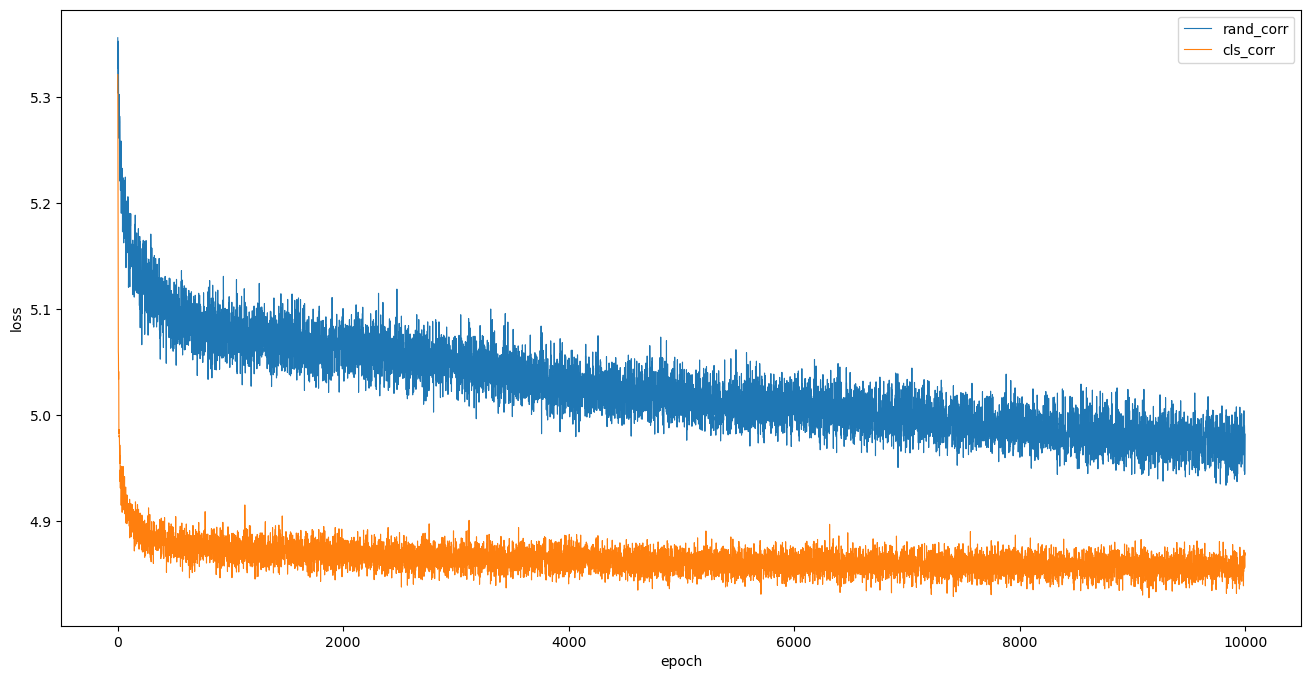

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['rand_corr', 'cls_corr']:
    ax.plot(loss_histories[key], label=key, linewidth=0.8)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

# Evaluate embeddings

In [23]:
train_loader = DataLoader(train_dses['rand_corr'], batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dses['rand_corr'], batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in ['rand_corr', 'cls_corr']:
    train_embeddings[key] = models[key].get_dataset_embeddings(train_loader)
    test_embeddings[key] = models[key].get_dataset_embeddings(test_loader)
    print(train_embeddings[key].shape)
    print(test_embeddings[key].shape)

(455, 16)
(114, 16)
(455, 16)
(114, 16)


In [24]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
test_predictions = clf.predict(test_data)
print("Classification report for direct fitting inputs:")
print(classification_report(test_target, test_predictions))


# embeddings dataset: train the classifier on the embeddings
for key in ['rand_corr', 'cls_corr']:
    clf.fit(train_embeddings[key], train_target)
    vanilla_predictions = clf.predict(test_embeddings[key])
    print(f"Classification report using {key} embeddings:")
    print(classification_report(test_target, vanilla_predictions))

Classification report for direct fitting inputs:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Classification report using rand_corr embeddings:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Classification report using cls_corr embeddings:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                      

# Visualzie using t-sne 

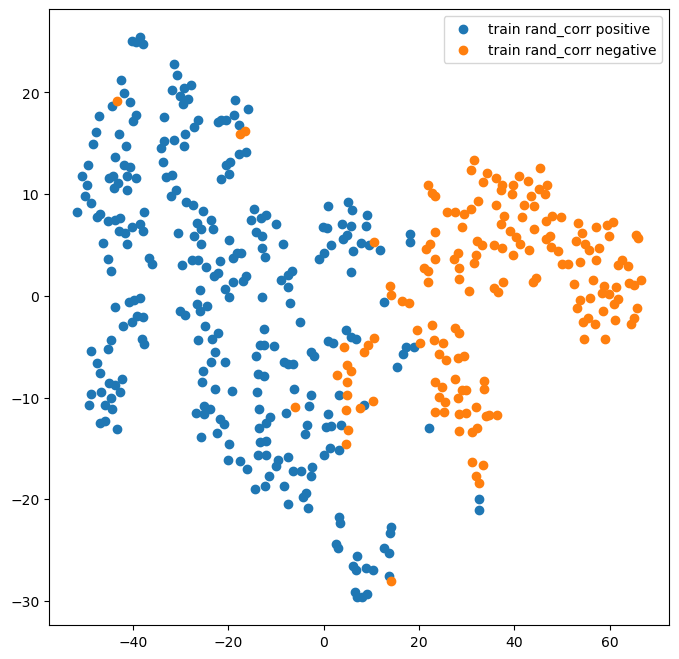

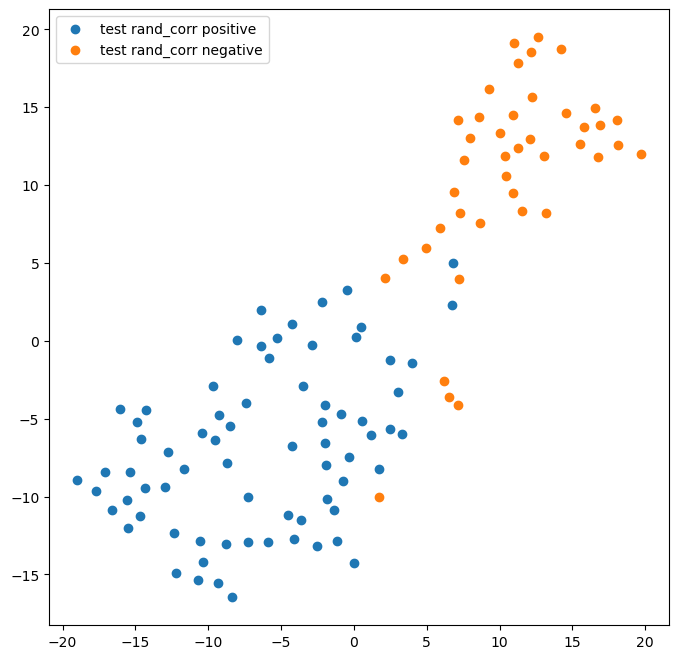

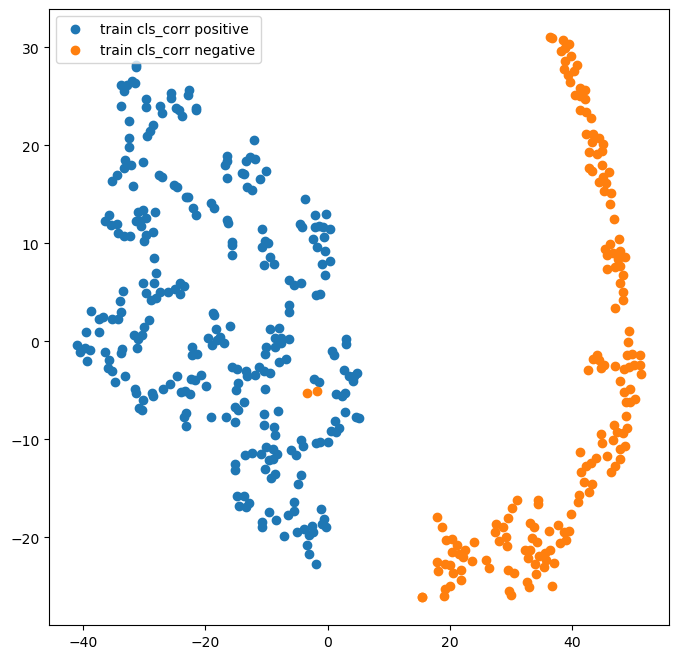

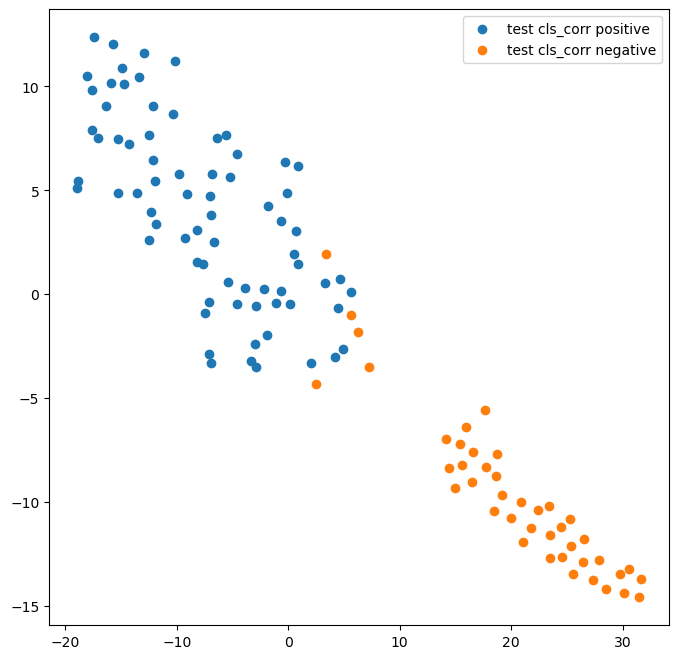

In [25]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
for key in ['rand_corr', 'cls_corr']:
    reduced = tsne.fit_transform(train_embeddings[key])
    positive = train_target == 1

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(reduced[positive, 0], reduced[positive, 1], label=f"train {key} positive")
    ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label=f"train {key} negative")
    plt.legend()

    reduced = tsne.fit_transform(test_embeddings[key])
    positive = test_target == 1

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(reduced[positive, 0], reduced[positive, 1], label=f"test {key} positive")
    ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label=f"test {key} negative")
    plt.legend()

    plt.show()